In [34]:
import networkx as nx
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

# WEEK 5

In Week 5, we focused on advanced network analysis by implementing algorithms to uncover the graph's structural hierarchy and identify influential nodes. 
First, we computed the PageRank of the network to rank nodes based on their relative importance, reflecting how interactions flow through the graph.

Next, we programmed a custom function to calculate the k-shell decomposition, which identifies the k-core and (k+1)-core subgraphs for all possible values of k. This analysis helps pinpoint the graph's core structure, where higher k-values represent nodes with stronger connectivity.

Finally, we plotted the (k+1)-core subgraph for an appropriate choice of k, depending on the focus of the analysis. To highlight the most connected and central characters, we selected k ≥ 12 or k ≥ 13, as this aligns with the observed distribution (maximum k = 18). This allowed us to visualize the core characters and understand their central role in the network.

We're defining a function that reads from the txt file and and creates a directed graph where each edge treated as bidirectional (because in the instruction, we're told to treat our graph as unweighted and and biderctional):

In [35]:
def read_graph_from_file(file_path):
    G = nx.DiGraph() # creates a directed graph object (DiGraph) using NetworkX
    with open(file_path, "r") as file: # opens and reads the specified file
        for line in file: # iterates through each line
            line = line.strip() # remove leading and trailing whitespace from the line
            if line.startswith("#"): # checks if the line is a comment (starts with '#')
                continue  #ignores comment lines
            nodes = line.split()  #splits the line based on whitespace to get the nodes 
            if len(nodes) == 2: #treats undirected edges as bidirectional edges 
                #adds the edges
                G.add_edge(nodes[0], nodes[1])
                G.add_edge(nodes[1], nodes[0])
    return G #returns the constructed graph

Example usage of the file reading function and creating a graph:

In [36]:
#defining file path
file_path = "friends_episodes.txt" 

#creating a graph
G = read_graph_from_file(file_path)

Checking if the graph is connected with built-in function:

In [37]:
if not nx.is_strongly_connected(G): #if it is not connected, only proceed with the largest component
    largest_cc = max(nx.strongly_connected_components(G), key=len)  # 'nx.strongly_connected_components(G)' returns all strongly connected components as sets of nodes
    # 'max()' selects the largest component based on the number of nodes
    
    G = G.subgraph(largest_cc).copy() # extracts the subgraph corresponding to the largest strongly connected component

Running built-in PageRank function with alpha = 0.15 (given in the instructions):

In [38]:
pagerank_scores = nx.pagerank(G, alpha=0.15)
print(pagerank_scores)

{'Monica': 0.01572621026269626, 'Joey': 0.024639450992840577, 'Chandler': 0.01913781502390483, 'Phoebe': 0.016305389900644455, 'Ross': 0.021014453333537495, 'Rachel': 0.01785536544874614, 'waitress': 0.0011610810320841697, 'LeonardGreen': 0.001453788240647082, 'Paul': 0.001211946468488567, 'Barry': 0.001537336341202446, 'Franny': 0.0011493076959383708, 'Marsha': 0.0011693327002686449, 'Carol': 0.0014765533183350344, 'Judy': 0.0016217265862127441, 'Jack': 0.001509112977822839, 'Susan': 0.0013303897043582362, 'Robbie': 0.0011880913866434395, 'DrOberman': 0.0012033975463256303, 'Mindy': 0.001263683209793329, 'Paula': 0.0011493076959383708, 'Alan': 0.001211946468488567, 'Lizzy': 0.0011497854237733122, 'Allan': 0.001161449372088707, 'Joanne': 0.0011610810320841697, 'Kiki': 0.0012428644260784171, 'Leslie_1_4': 0.0011496582089704308, 'nurseSizemore': 0.0011768497582803487, 'pizzaGuy': 0.00117298158303285, 'brattyBoy': 0.0011508849521248946, 'neighbor': 0.001150026548974968, 'visaCardGuy': 0.0

Computing the node with highest PageRank score: 

In [39]:
highest_pagerank_node = max(pagerank_scores, key=pagerank_scores.get)
print(f"The node with the highest PageRank is: {highest_pagerank_node} with value {pagerank_scores[highest_pagerank_node]}")

The node with the highest PageRank is: Joey with value 0.024639450992840577


The node with the hishest PageRank and highest closeness centrality score was Joey
but the value for each parameter differs because PageRank emphasizes on link quality
this means that the node doesn't just each other nodes quickly, but it is also influential in terms of network structure since there might be a lot of links pointing to a node.
However, since closeness centrality value is higher than PageRank value, the node "Joey" was the most well-connected, but not necessarilty the most "influential" hub in terms of link quality 

Plotting the cumulative distribution of PageRank scores:

In [40]:
# defining a function that plots the distribution: 

def plot_cumulative_distribution(scores):
    sorted_values = np.sort(list(scores.values())) #sorts the values in ascending order
    cumulative_counts = np.arange(1, len(sorted_values) + 1) / len(sorted_values) #computes the cumultive proportions for each sorted value, ranking each score by the proportion of nodes with a score equal/less to it 
#plots the distribution and adjusting parameters 
    plt.figure(figsize=(12, 6))
    plt.plot(sorted_values, cumulative_counts, marker='o', linestyle='none')
    plt.title("Cumulative Distribution of PageRank Scores") #adds titile to the plotted graph
    plt.xlabel("PageRank Score") #PageRank scores on the x-axis
    plt.ylabel("Cumulative Proportion") #cumulative proportions on y-axis
    plt.grid()# adds a grid to the plot for better readability
    
    plt.xscale('log') #logarithmic scales to help visualize distribution more clearly, cosidering the heavy-tail or outliers 
    plt.yscale('log')
    plt.show() #displays the plot

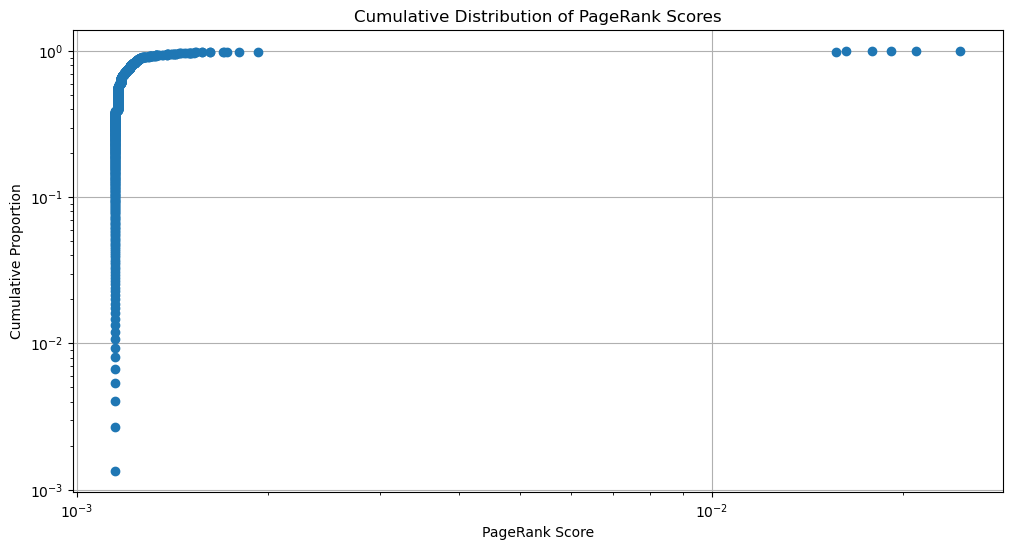

In [41]:
plot_cumulative_distribution(pagerank_scores)

It is a plot with steep initial rise indicating that most nodes(characters) have lower PageRank, meaning that the "influence" is concentrated more on small portion of nodes
there are small number of nodes with the most "influence"

If we comparare it to cumulative distribution of closeness centrality scores, it has more gradual rise, indicating that the nodes are more evenly reachable in terms of path distance

We're creating function for computing the k-shell and k+1 core:

In [42]:
#function to compute k-shell

def k_shell(graph, k): 
    # computing the k-shell of the graph
    G_copy = graph.copy()
    while True:
        # removing nodes with degree smaller than k
        nodes_to_remove = [node for node, degree in dict(G_copy.degree()).items() if degree < k]
        G_copy.remove_nodes_from(nodes_to_remove)
        if not nodes_to_remove:  # breaks the loop, if no more nodes to remove
            break

    return G_copy # returning the updated graph nodes removed

In [43]:
# function to compute k+1-core (k-shell for k+1)
def k_plus_1_core(graph, k):
    # computing the k-shell and then find the k+1 core from it
    k_core_graph = k_shell(graph, k)
    return k_shell(k_core_graph, k + 1)

To choose the adequate value for k, we can explore the graph for k-shell index maximum and distribution:

In [44]:
#computing the k-shell index for every node in the graph:
k_shell_indices = nx.core_number(G)

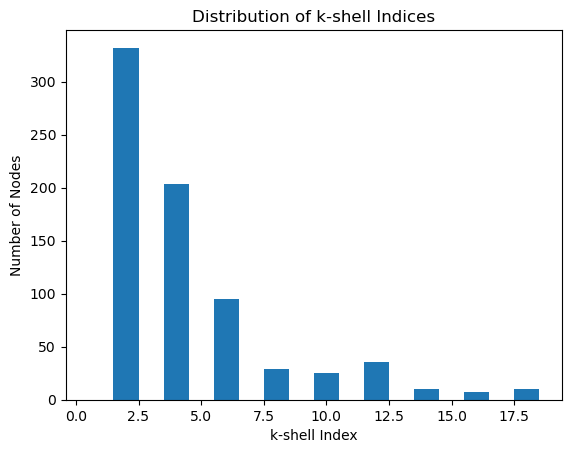

In [45]:
#plotting the dictribution of k-shell indices: 

plt.hist(k_shell_indices.values(), bins=range(1, max(k_shell_indices.values()) + 2), align='left')
plt.xlabel('k-shell Index') #labels the x-axis
plt.ylabel('Number of Nodes') #labels the y-axis
plt.title('Distribution of k-shell Indices') #add a title 
plt.show()

In [46]:
#checking for maximum k-shell value:
max_k_shell = max(k_shell_indices.values())
print(f"Maximum k-shell value: {max_k_shell}")

Maximum k-shell value: 18


We can choose value for k depending on what information about the graph we need. If we want to get a closer look on core characters (most connected and central nodes), considering that the maximum value for k is 18 and based on distribution, we can choose k>=12 or k>=13

Computing the k-shell, k+1 core and plotting for k=12:

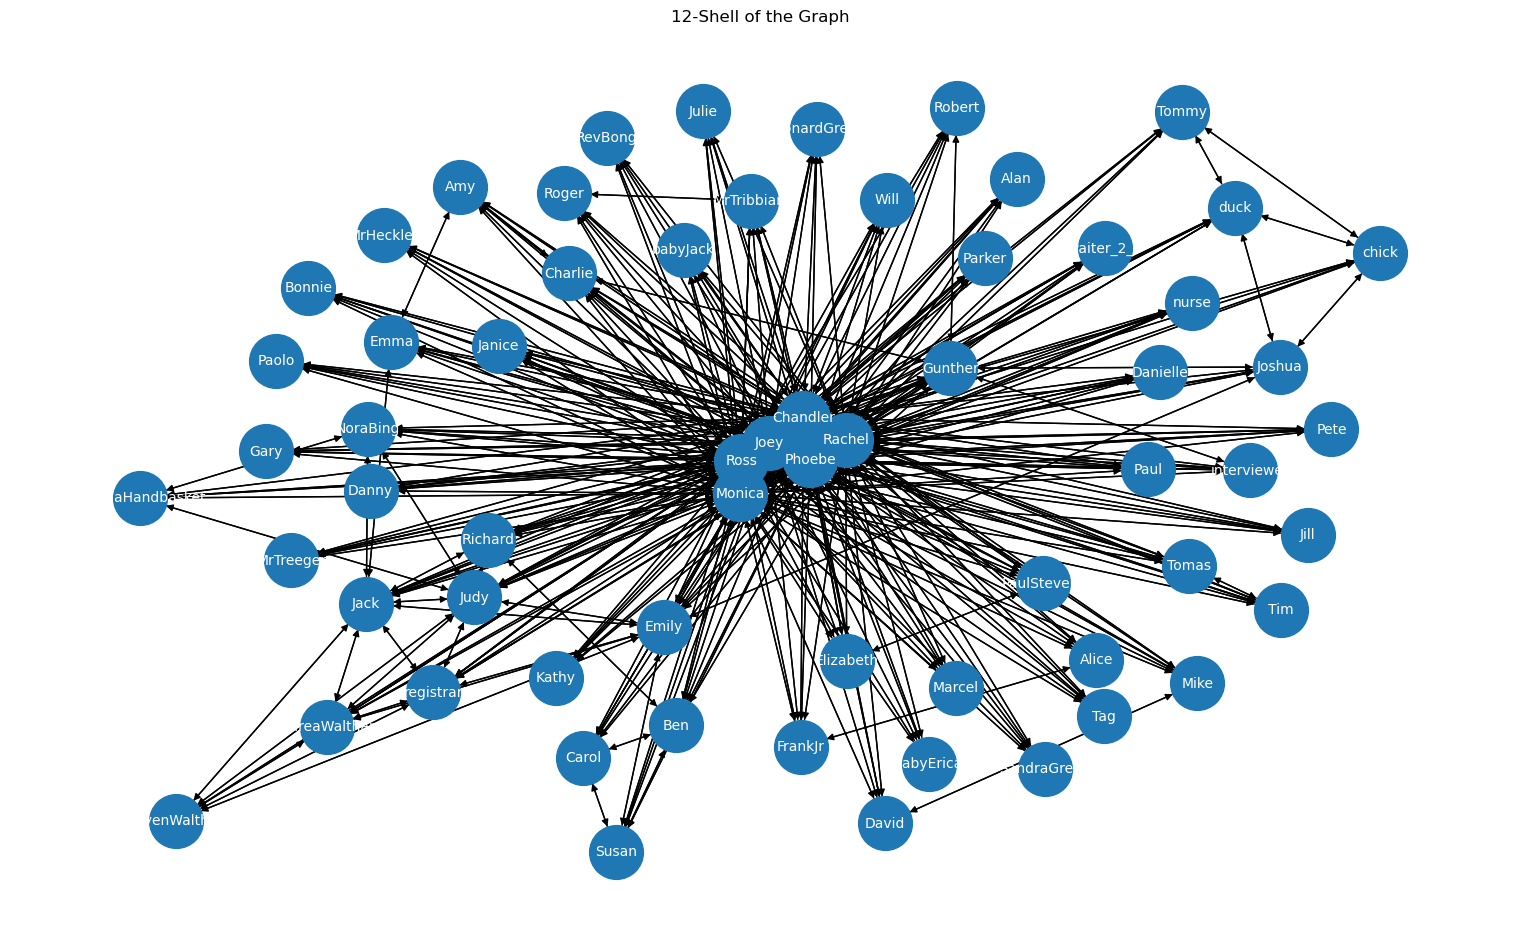

In [47]:
k_value = 12  #setting a k value

#computing the k-shell and k+1 using the funcitons we created
k_shell_graph = k_shell(G, k_value)
k_plus_1_core_graph = k_plus_1_core(G, k_value)

#plotting the k-shell
plt.figure(figsize=(15, 9)) #plot size parameters 
nx.draw(k_shell_graph, with_labels=True, node_size=1500, font_size=10, font_color='white') #adjusting paraeters for better visualization
plt.title(f"{k_value}-Shell of the Graph") #adds a title 
plt.show()

Computing the k-shell, k+1 core and plotting for k=15:

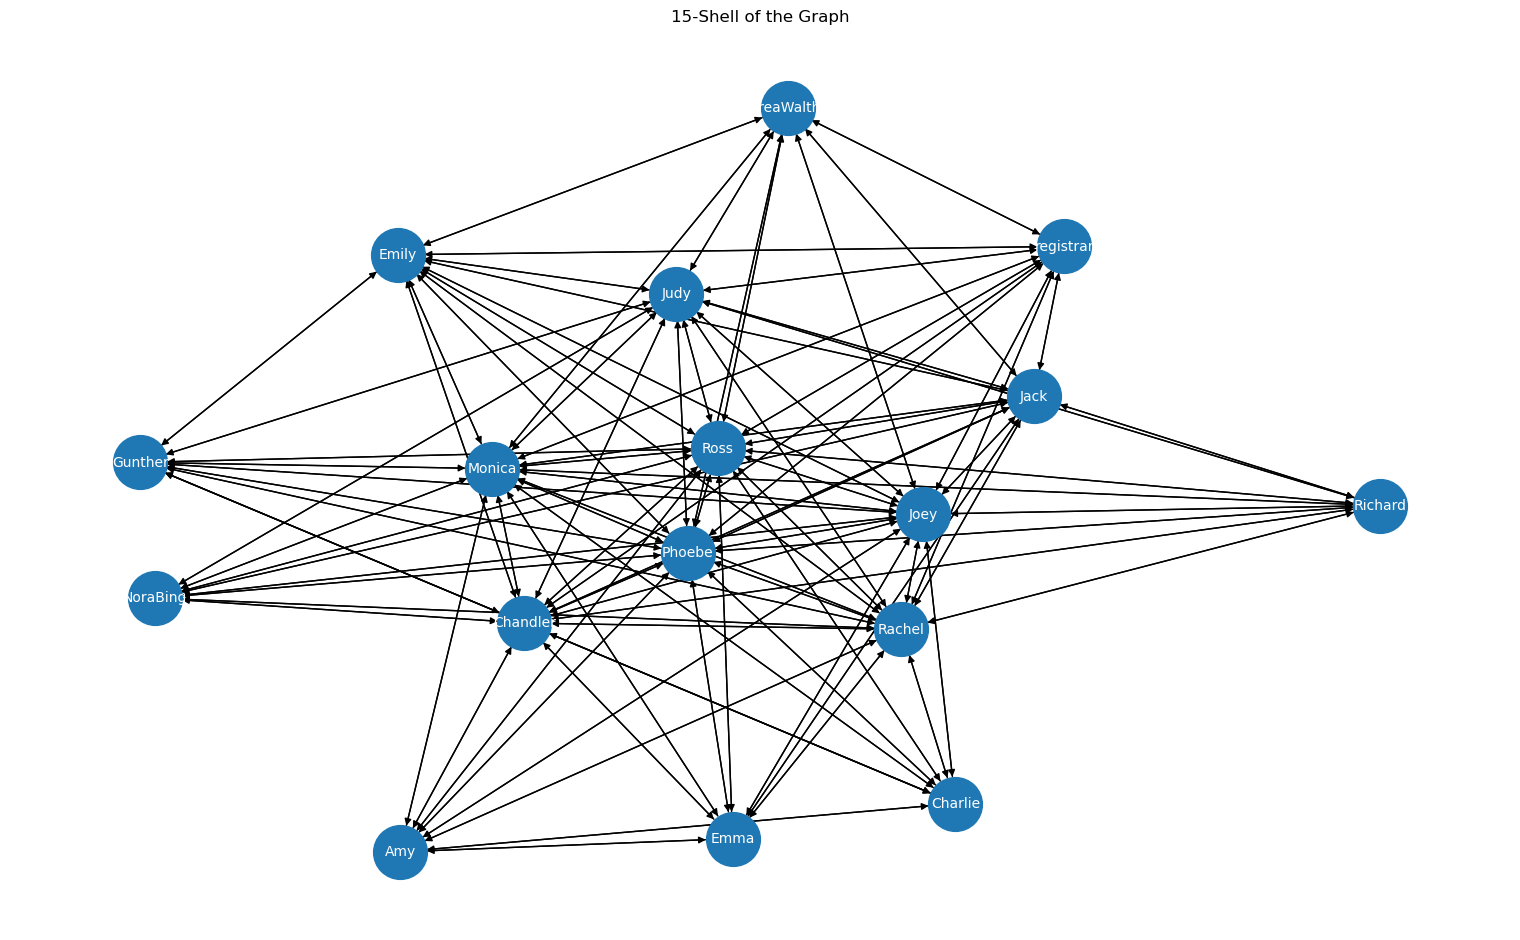

In [48]:
k_value = 15  #setting a k value

#computing the k-shell and k+1 using the funcitons we created
k_shell_graph = k_shell(G, k_value)
k_plus_1_core_graph = k_plus_1_core(G, k_value)

#plotting the k-shell
plt.figure(figsize=(15, 9)) #plot size parameters 
nx.draw(k_shell_graph, with_labels=True, node_size=1500, font_size=10, font_color='white') #adjusting paraeters for better visualization
plt.title(f"{k_value}-Shell of the Graph") #adds a title 
plt.show()

# WEEK 7 

For week 7: The code takes as input the interactions from each episode from “Friends.” It analyses the social network by identifying potential new connections among characters. Using graph theory, it extracts the largest connected component and computes link prediction indices: Common Neighbors (CN), Jaccard Index (JI), Adamic-Adar (AA), Preferential Attachment (PA), and Resource Allocation (RA). After that it makes sure the results are normalized and aggregated into scores (mean, sum, and a custom index created by the multiplication of Common Neighbours and Jaccard Index) for ranking missing links. The output gives the top ten missing links by these indices. Furthermore, the key findings include Joey and Joshua having the highest prediction score (3.572038), suggesting a strong likelihood of interaction based on shared connections. This result is interesting because in the show these two characters are not friends but indeed have a strong connectedness and probability of interaction due to these measures. The product-based "New Score" offers further insights, emphasizing links with proportionally strong commonality. This demonstrates practical applications of network science in predicting social dynamics.

In [49]:
# First, we initialize an empty graph
G = nx.Graph()

# Then we load and read the file and process each line
with open("friends_episodes.txt", "r") as file:
    for line in file:
        if line.startswith("#") or line.strip() == "": #continue without regarding comments or empty lines
            continue  
        
        #To visualize the nodes we split the line and check if it has exactly two parts
        parts = line.strip().split()
        if len(parts) != 2:
            continue  #We skip lines that don’t have exactly two words aka characters, because then there wouldn't be a dialogue.
        
        #Extract character names
        character1, character2 = parts
        
        
        #Add an undirected edge between the two characters (dialogues)
        G.add_edge(character1, character2)

#Now we remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

#Now that we have implemented the edges and removed self loops, we must extract the largest connected component
largest_cc = max(nx.connected_components(G), key=len) #connectedness comparison is done using the length 
G_largest_cc = G.subgraph(largest_cc).copy() #we visualize the subgraph created by the largest connected component set.
#.copy helps us see this subgraph as an independent one that contains only the nodes and edges of the largest connected component. 

We create a function to identify missing links via indices such as CN, JI, AA, PA, RA. 

In [50]:
def compute_indices(graph, missing_links): 
    common_neighbors = []
    jaccard_index = []
    adamic_adar = []
    preferential_attachment = []
    resource_allocation = []
    #we create an empty list for all of these indices for now to store information in them later in the code.

    for u, v in missing_links:
            #we will now use the built-in networkx functions to find the indices CN, JI, AA, PA, RA and append them to their designated spaces. 
            #Common Neighbors
            cn = len(list(nx.common_neighbors(graph, u, v))) 
            common_neighbors.append(cn)
            
            #Jaccard Index
            jaccard = list(nx.jaccard_coefficient(graph, [(u, v)]))[0][2]
            jaccard_index.append(jaccard)
        
            aa = list(nx.adamic_adar_index(graph, [(u, v)]))[0][2]
            adamic_adar.append(aa)
        
            #Preferential Attachment 
            pa = len(graph[u]) * len(graph[v])
            preferential_attachment.append(pa)
        
            #Resource Allocation Index 
            ra = list(nx.resource_allocation_index(graph, [(u, v)]))[0][2]
            resource_allocation.append(ra)
            
    # Now we must create a pandaframe to store results

    df = pd.DataFrame({
    'link': missing_links,
    'CN': common_neighbors,
    'JI': jaccard_index,
    'AA': adamic_adar,
    'PA': preferential_attachment,
    'RA': resource_allocation
    })  

    #we iterate over the columns which are the indices we have calculated before
    for col in ['CN', 'JI', 'AA', 'PA', 'RA']:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
        #we use the normalization formula to rescale each column between 0 and 1. 

    #Now we compute the arithmetic mean of CN and JI to create another index column
    df['Mean_Score'] = df[['CN', 'JI']].mean(axis=1) #axis=1 calculates for each row instead of column 

    #Add another column with the sum of CN and JI
    df['Sum_Score'] = df['CN'] + df['JI']
    
    return df

This line creates a list comprehension that generates a list of missing links in the graph G_largest_cc:


In [51]:
missing_links = [(u, v) for u in G_largest_cc.nodes() for v in G_largest_cc.nodes() if u != v and not G_largest_cc.has_edge(u, v)]

In [52]:
#If there are no missing links, print error
if not missing_links:
    print("Error")
else:
    #Recall our function compute_indices for the missing links
    df_indices = compute_indices(G_largest_cc, missing_links)
    print("Indices DataFrame:")

    top_10_cn = df_indices.sort_values(by='CN', ascending=False).head(10)
    top_10_mean = df_indices.sort_values(by='Mean_Score', ascending=False).head(10)
    top_10_sum = df_indices.sort_values(by='Sum_Score', ascending=False).head(10)


    print("\nTop 10 Missing links by Common Neighbors:")
    print(top_10_cn)
    print("\nTop 10 Missing links by Mean Score:")
    print(top_10_mean)
    print("\nTop 10 Missing links by Sum Score:")
    print(top_10_sum)

Indices DataFrame:

Top 10 Missing links by Common Neighbors:
                             link   CN        JI        AA        PA  \
2797      (Rachel, AndreaWaltham)  1.0  0.034934  0.830983  0.695962   
252052    (AndreaWaltham, Rachel)  1.0  0.034934  0.830983  0.695962   
735                (Joey, Joshua)  1.0  0.029520  0.914645  1.000000   
257400       (registrar, Gunther)  1.0  0.363636  0.683758  0.072956   
44083         (NoraBing, Richard)  1.0  0.500000  0.680832  0.048185   
257427       (registrar, Richard)  1.0  0.470588  0.680832  0.052596   
1224    (Chandler, AndreaWaltham)  1.0  0.033613  0.830983  0.723448   
133877        (Richard, NoraBing)  1.0  0.500000  0.680832  0.048185   
257306      (registrar, NoraBing)  1.0  0.533333  0.680832  0.044452   
134133           (Richard, Emily)  1.0  0.380952  0.680832  0.070241   

              RA  Mean_Score  Sum_Score  
2797    0.442897    0.517467   1.034934  
252052  0.442897    0.517467   1.034934  
735     0.627873   

Result Debrief: 
Symmetric edge pairs like (A,B) and (B,A) produce the same result because it is an undirected and unweighted graph. 
A CN value of 1 indicates that the pairs have the same number of common neighbors. 
The mean will give us a more balanced view, and the score of the highest scoring pairs are 0.875, which is close to 1 and that indicates that these pairs have strong connections
The sum score of the highest scoring pairs are 1.75, which means that these pairs have a cumulative result based on CN+JI that is likely to be connected in the future.
The product of CN*JI emphasizes links where both indices are high. Pairs with a higher score have a stronger potential to form a link.
Higher values of CN * JI indicate that two nodes not only have many common neighbors but also share a high proportion of neighbors relative to their total neighbors.

Lastly, we can have fun with it and invent a new index!

In [53]:
df_indices['New_Score'] = df_indices['CN'] * df_indices['JI']  #New score (product of CN and JI)
top_10_new = df_indices.sort_values(by='New_Score', ascending=False).head(10)
print("\nTop 10 Missing links by New Score (CN * JI):")
print(top_10_new)


Top 10 Missing links by New Score (CN * JI):
                       link    CN   JI        AA        PA        RA  \
434717       (Parker, Jill)  0.75  1.0  0.418253  0.011876  0.042122   
4695    (Paul, SandraGreen)  0.75  1.0  0.418253  0.011876  0.042122   
420153         (Will, Paul)  0.75  1.0  0.418253  0.011876  0.042122   
4950           (Paul, Gary)  0.75  1.0  0.418253  0.011876  0.042122   
13564   (Alan, SandraGreen)  0.75  1.0  0.418253  0.011876  0.042122   
101126   (waiter_2_5, Paul)  0.75  1.0  0.418253  0.011876  0.042122   
101138   (waiter_2_5, Alan)  0.75  1.0  0.418253  0.011876  0.042122   
13568    (Alan, waiter_2_5)  0.75  1.0  0.418253  0.011876  0.042122   
434668       (Parker, Gary)  0.75  1.0  0.418253  0.011876  0.042122   
4944        (Paul, RevBong)  0.75  1.0  0.418253  0.011876  0.042122   

        Mean_Score  Sum_Score  New_Score  
434717       0.875       1.75       0.75  
4695         0.875       1.75       0.75  
420153       0.875       1.75   

To make some predictions for new links considering the show and the results we got, we could say:
Prediction Score = CN+JI+AA+PA+RA
Prediction scores for Rachel and AndreaWaltham: 3.004776
Prediction scores for Joey and Joshua: 3.572038
Prediction score for registrar and Gunther: 2.348017
Prediction score for Chandler and AndreaWaltham: 3.031941
Top Prediction score is 3.572038 from Joey and Joshua,
These predictions suggest that these links have the highest likelihood of forming new connections.
Joey and Joshua will most likely form a new connection in the series. This is interesting because these two are not friends, but rather share many connections that would mathematically suggest they would be friends as per the friends of friends theory.